Geometry: NDBR50, Epoch [100/1000], Loss: 59906.6797
Geometry: NDBR50, Epoch [200/1000], Loss: 59843.1797
Geometry: NDBR50, Epoch [300/1000], Loss: 59821.2578
Geometry: NDBR50, Epoch [400/1000], Loss: 59794.2617
Geometry: NDBR50, Epoch [500/1000], Loss: 59761.0469
Geometry: NDBR50, Epoch [600/1000], Loss: 59720.1055
Geometry: NDBR50, Epoch [700/1000], Loss: 59669.3281
Geometry: NDBR50, Epoch [800/1000], Loss: 59605.6914
Geometry: NDBR50, Epoch [900/1000], Loss: 59525.5117
Geometry: NDBR50, Epoch [1000/1000], Loss: 59424.8750
Geometry: NDBR6, Epoch [100/1000], Loss: 59299.9414
Geometry: NDBR6, Epoch [200/1000], Loss: 59146.7734
Geometry: NDBR6, Epoch [300/1000], Loss: 58961.2930
Geometry: NDBR6, Epoch [400/1000], Loss: 58739.7734
Geometry: NDBR6, Epoch [500/1000], Loss: 58479.6133
Geometry: NDBR6, Epoch [600/1000], Loss: 58179.9180
Geometry: NDBR6, Epoch [700/1000], Loss: 57841.4453
Geometry: NDBR6, Epoch [800/1000], Loss: 57466.1328
Geometry: NDBR6, Epoch [900/1000], Loss: 57057.4102
G

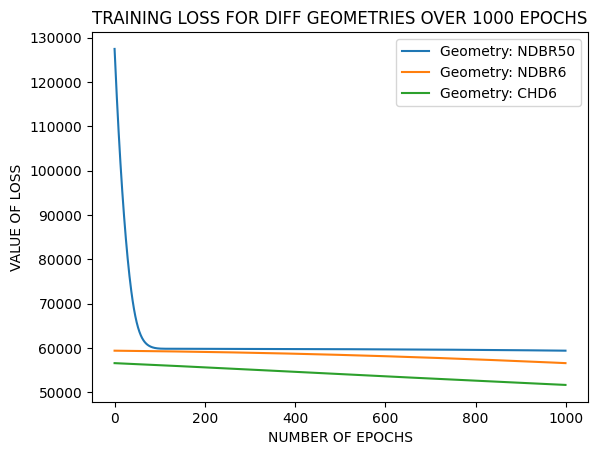

Predicted parameters for geometry NDBR50:
{'c1': 2.8205437660217285, 'c2': 42.996734619140625, 'c3': 22.55011558532715, 'c4': -0.16360855102539062, 'c5': 362.302490234375, 'c6': 37.814937591552734, 'c7': 70.42505645751953}
Predicted parameters for geometry NDBR6:
{'c1': 2.4008774757385254, 'c2': 38.23786544799805, 'c3': 20.079206466674805, 'c4': -0.07751071453094482, 'c5': 319.55072021484375, 'c6': 33.64031219482422, 'c7': 62.405517578125}
Predicted parameters for geometry CHD6:
{'c1': 2.807335376739502, 'c2': 41.359798431396484, 'c3': 21.919410705566406, 'c4': -0.07179892063140869, 'c5': 349.1904296875, 'c6': 36.48124694824219, 'c7': 67.90283966064453}


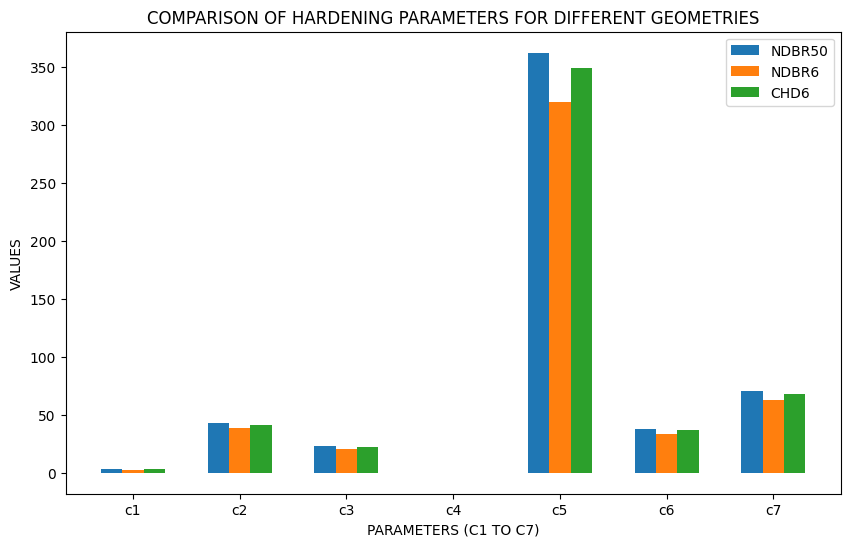

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

paramConfig = {
    'c1': {'lowerBound': 0, 'upperBound': 1, 'exponent': 1.0, 'name': 'W', 'unit': 'dimensionless', 'type': 'hardening'},
    'c2': {'lowerBound': 0, 'upperBound': 2, 'exponent': 1000.0, 'name': 'K', 'unit': 'MPa', 'type': 'yielding'},
    'c3': {'lowerBound': 0, 'upperBound': 1, 'exponent': 0.1, 'name': 'e0', 'unit': 'dimensionless', 'type': 'hardening'},
    'c4': {'lowerBound': 0, 'upperBound': 1, 'exponent': 1.0, 'name': 'n', 'unit': 'dimensionless', 'type': 'hardening'},
    'c5': {'lowerBound': 0, 'upperBound': 2, 'exponent': 1000.0, 'name': 'sigma_y', 'unit': 'MPa', 'type': 'yielding'},
    'c6': {'lowerBound': 0, 'upperBound': 1, 'exponent': 1000.0, 'name': 'sigma_sat', 'unit': 'MPa', 'type': 'hardening'},
    'c7': {'lowerBound': 0, 'upperBound': 1, 'exponent': 1000.0, 'name': 'b', 'unit': 'dimensionless', 'type': 'hardening'}
}

geometries = ['NDBR50', 'NDBR6', 'CHD6']

yieldingIndices = {'NDBR50': 200, 'NDBR6': 200, 'CHD6': 1200}

# Load data from CSV files
X_file = "MODEL_DATA/reduced_fd.csv"
Y_file = "MODEL_DATA/converted.csv"

X_df = pd.read_csv(X_file)  # Load the X data
Y_df = pd.read_csv(Y_file)  # Load the Y data

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_df.values, dtype=torch.float32)
Y_train = torch.tensor(Y_df.values, dtype=torch.float32)

# Define a simple neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the number of input features, hidden units, and output dimensions
input_size = X_train.shape[1]  # Number of input parameters
hidden_size = 64  # Number of hidden units
output_size = Y_train.shape[1]  # Number of output dimensions

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size, output_size)

# Define a loss function (mean squared error) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000  # Adjust the number of epochs as needed

# Lists to store loss values for each geometry
loss_lists = {geometry: [] for geometry in geometries}

for geometry in geometries:
    num_samples = yieldingIndices[geometry]  # Use the yielding index for the current geometry

    # Select the relevant samples from X and Y
    X_sample = X_train[:num_samples]
    Y_sample = Y_train[:num_samples]

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_sample)

        # Compute the loss
        loss = criterion(outputs, Y_sample)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_lists[geometry].append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Geometry: {geometry}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the loss for each geometry in a single graph
for geometry in geometries:
    plt.plot(loss_lists[geometry], label=f'Geometry: {geometry}')

# Rest of your code for prediction and visualization
plt.xlabel('NUMBER OF EPOCHS')
plt.ylabel('VALUE OF LOSS')
plt.legend()
plt.title('TRAINING LOSS FOR DIFF GEOMETRIES OVER 1000 EPOCHS')
plt.show()

# Predict parameters for all geometries
predicted_parameters = {}

for geometry in geometries:
    X_test = torch.rand((1, input_size))
    with torch.no_grad():
        predictions = model(X_test)

    # Convert predictions to a dictionary
    predicted_params = {param: value.item() for param, value in zip(paramConfig.keys(), predictions[0])}
    predicted_parameters[geometry] = predicted_params

# Print predicted parameters for all geometries
for geometry, params in predicted_parameters.items():
    print(f'Predicted parameters for geometry {geometry}:')
    print(params)

# Visualize 'c1' to 'c7' values for each geometry in a single graph with 'c1' to 'c7' on the x-axis
param_names = list(paramConfig.keys())
num_params = len(param_names)

fig, ax = plt.subplots(figsize=(10, 6))
width = 0.2
x = np.arange(len(param_names))

for i, geometry in enumerate(geometries):
    param_values = [predicted_parameters[geometry][param_name] for param_name in param_names]
    ax.bar(x + i * width, param_values, width=width, label=geometry)

ax.set_xlabel('PARAMETERS (C1 TO C7)')
ax.set_ylabel('VALUES')
ax.set_title('COMPARISON OF HARDENING PARAMETERS FOR DIFFERENT GEOMETRIES')
ax.set_xticks(x + width * (len(geometries) - 1) / 2)
ax.set_xticklabels(param_names)
ax.legend()

plt.show()

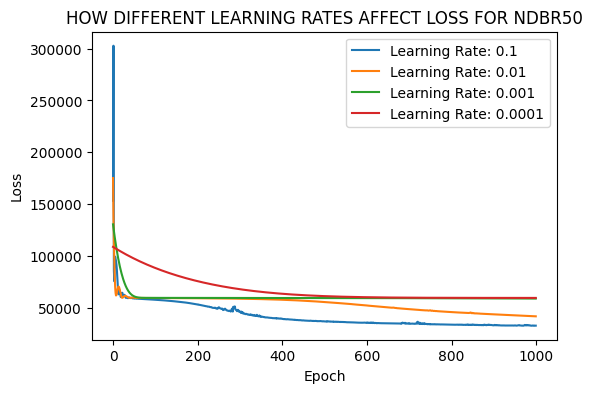

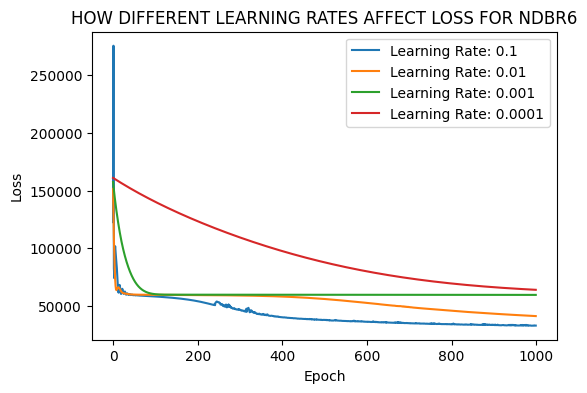

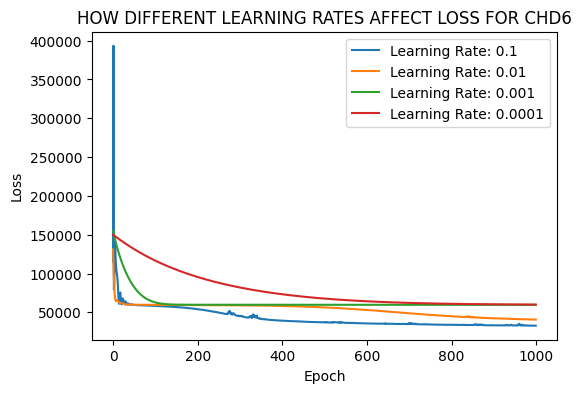

In [5]:
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Define a range of learning rates to experiment with
learning_rates = [0.1, 0.01, 0.001, 0.0001]
lr_losses = {lr: [] for lr in learning_rates}

# Lists to store loss values for each geometry
loss_lists = {geometry: {lr: [] for lr in learning_rates} for geometry in geometries}

for geometry in geometries:
    num_samples = yieldingIndices[geometry]  # Use the yielding index for the current geometry

    # Load data from CSV files
    X_df = pd.read_csv("MODEL_DATA/reduced_fd.csv")
    Y_df = pd.read_csv("MODEL_DATA/converted.csv")

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_df.values, dtype=torch.float32)
    Y_train = torch.tensor(Y_df.values, dtype=torch.float32)

    for lr in learning_rates:
        # Create a new instance of the neural network
        model = NeuralNetwork(input_size, hidden_size, output_size)

        # Define a new optimizer with the current learning rate
        optimizer = optim.Adam(model.parameters(), lr=lr)

        loss_lists[geometry][lr] = []  # Reset the loss list for the current geometry and learning rate

        for epoch in range(num_epochs):
            # Forward pass
            outputs = model(X_train)

            # Compute the loss
            loss = criterion(outputs, Y_train)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_lists[geometry][lr].append(loss.item())

# Plot the loss curves for different learning rates
for geometry in geometries:
    plt.figure(figsize=(6, 4))  # Adjust the figsize for smaller images
    for lr in learning_rates:
        plt.plot(loss_lists[geometry][lr], label=f'Learning Rate: {lr}')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'HOW DIFFERENT LEARNING RATES AFFECT LOSS FOR {geometry}')
    plt.show()


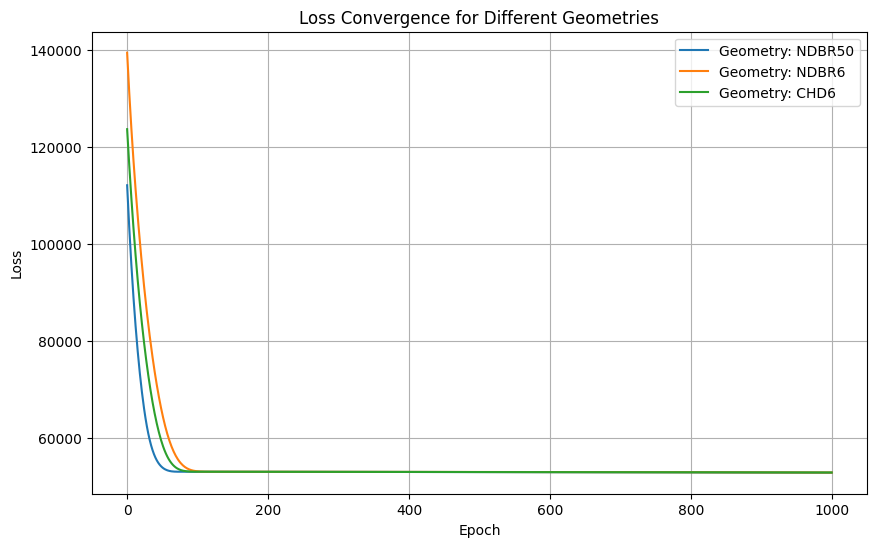

In [8]:
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the number of epochs and convergence threshold
num_epochs = 1000
convergence_threshold = 0.01  # Adjust this threshold as needed

# Lists to store convergence epochs for each geometry
convergence_epochs = {}

# Create a new figure for the convergence plot
plt.figure(figsize=(10, 6))

for geometry in geometries:
    num_samples = yieldingIndices[geometry]  # Use the yielding index for the current geometry

    # Load data from CSV files
    X_df = pd.read_csv("MODEL_DATA/reduced_fd.csv")
    Y_df = pd.read_csv("MODEL_DATA/converted.csv")

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_df.values, dtype=torch.float32)
    Y_train = torch.tensor(Y_df.values, dtype=torch.float32)

    # Create a new instance of the neural network
    model = NeuralNetwork(input_size, hidden_size, output_size)

    # Define a new optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store loss values during training
    loss_values = []

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)

        # Compute the loss
        loss = criterion(outputs, Y_train)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

        # Check for convergence
        if epoch > 0 and abs(loss_values[epoch] - loss_values[epoch - 1]) < convergence_threshold:
            convergence_epochs[geometry] = epoch
            break

    # Plot the loss curve for the current geometry
    plt.plot(loss_values, label=f'Geometry: {geometry}')

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Convergence for Different Geometries')
plt.grid(True)

# Show the convergence plot
plt.show()

# Print convergence epochs for each geometry
for geometry, epoch in convergence_epochs.items():
    print(f'Geometry: {geometry}, Convergence Epoch: {epoch}')


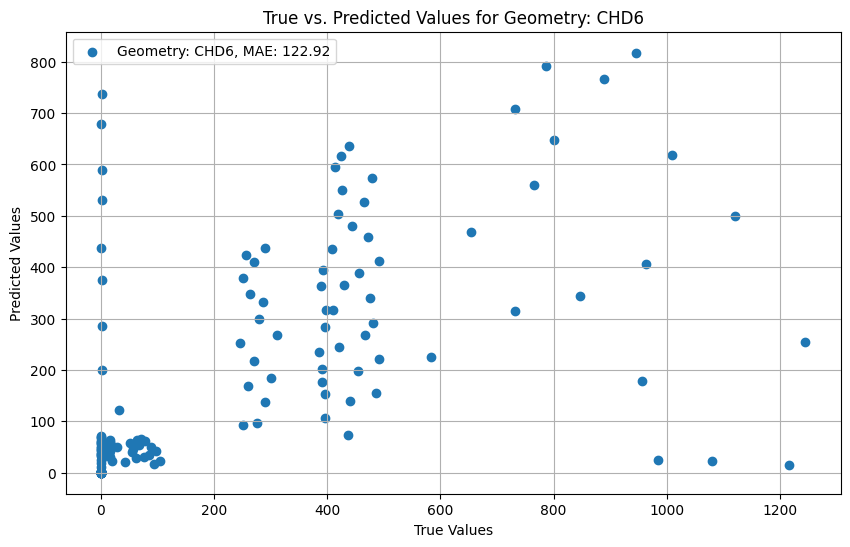

In [15]:
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Define the number of epochs and other constants
num_epochs = 1000
convergence_threshold = 0.01  
num_samples_per_geometry = 100 

# Create a new figure for the performance metrics plot
plt.figure(figsize=(10, 6))

# Specify the geometry you want to work with
geometry = "CHD6"

# Load data from CSV files
X_df = pd.read_csv("MODEL_DATA/reduced_fd.csv")
Y_df = pd.read_csv("MODEL_DATA/converted.csv")

# Convert data to PyTorch tensors
X_train = torch.tensor(X_df.values, dtype=torch.float32)
Y_train = torch.tensor(Y_df.values, dtype=torch.float32)

# Create a new instance of the neural network
model = NeuralNetwork(input_size, hidden_size, output_size)

# Define a new optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values during training
loss_values = []

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)

    # Compute the loss
    loss = criterion(outputs, Y_train)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())

    # Check for convergence
    if epoch > 0 and abs(loss_values[epoch] - loss_values[epoch - 1]) < convergence_threshold:
        convergence_epochs[geometry] = epoch
        break

# Calculate the Mean Absolute Error (MAE) for the CHD6 geometry
with torch.no_grad():
    predictions = model(X_train)
mae = mean_absolute_error(Y_train.numpy(), predictions.numpy())

# Plot the true values vs. predicted values for CHD6 geometry
plt.scatter(Y_train.numpy(), predictions.numpy(), label=f'Geometry: {geometry}, MAE: {mae:.2f}')

# Customize the performance metrics plot
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title(f'True vs. Predicted Values for Geometry: {geometry}')
plt.grid(True)

# Show the performance metrics plot
plt.show()
